In [4]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [5]:
pathTrain= '/content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/Dataset/Train/'

In [6]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [25]:
labels = ['NORMAL', 'MENINGIOMA', 'GLIOMA', 'PITUITARY']
#image size with 512 and 256 crashed the computation
img_size = 150
def get_data():
    data = [] 
    for label in labels: 
        path = os.path.join(pathTrain, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [26]:
train = get_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


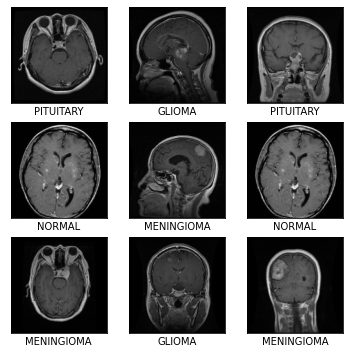

In [27]:
#plot random images from train dataset
from random import seed
from random import randint
plt.figure(figsize=(6,6))
for i in range(9): 
  value = randint(0, 3000)   
  plt.subplot(3,3,i+1)    
  plt.xticks([])    
  plt.yticks([])    
  plt.grid(False)
  plt.imshow(train[value][0], cmap=plt.cm.binary)    
  plt.xlabel(labels[train[value][1]])
plt.show()

In [28]:
x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

# Normalize the data
x_train = np.array(x_train)
x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

#shuffling
#indices = np.arange(y_train.shape[0])
#np.random.shuffle(indices)
#indices = list(indices)
#x_train = x_train[indices]
#y_train = y_train[indices]
print("x_train",x_train.shape)
print("y_train",y_train.shape)

x_train (2870, 150, 150, 3)
y_train (2870,)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train,y_train, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.5)
print("Training X Data Shape:", X_train.shape)
print("Testing X Data Shape:", X_test.shape)
print("Validation X Data Shape:", X_val.shape)
print("Training y Data Shape:", y_train.shape)
print("Testing y Data Shape:", y_test.shape)
print("Validation y Data Shape:", y_val.shape)

Training X Data Shape: (2296, 150, 150, 3)
Testing X Data Shape: (287, 150, 150, 3)
Validation X Data Shape: (287, 150, 150, 3)
Training y Data Shape: (2296,)
Testing y Data Shape: (287,)
Validation y Data Shape: (287,)


In [30]:
print(y_test)

[1 2 2 2 3 3 1 3 2 1 0 0 1 3 1 0 1 3 3 3 2 0 0 1 3 1 1 3 2 2 0 3 3 0 1 1 2
 1 0 3 2 0 1 1 1 2 3 2 2 1 2 1 1 3 2 2 2 3 1 0 1 2 3 2 2 3 2 1 2 3 3 3 2 1
 3 3 1 3 1 0 3 0 1 2 1 0 3 1 3 2 3 1 1 3 2 1 2 3 3 3 2 0 0 1 0 0 3 2 2 2 1
 3 0 0 2 1 1 1 2 2 2 2 1 3 0 1 1 3 3 1 0 3 0 2 2 2 3 3 1 1 2 0 3 1 2 3 3 3
 3 2 2 1 1 1 3 1 0 1 2 2 0 2 3 2 2 0 1 3 3 1 3 3 1 2 3 3 2 1 0 3 0 2 2 3 3
 0 0 3 1 1 0 1 3 0 1 2 1 3 3 3 3 3 2 2 1 2 1 2 0 3 2 3 2 1 1 2 3 1 3 3 1 0
 1 2 3 2 2 2 2 3 2 1 1 3 3 3 1 3 3 0 3 3 3 1 2 0 2 1 2 1 2 2 3 3 3 2 3 1 1
 0 3 3 0 2 3 3 1 3 2 2 2 3 2 3 2 2 2 3 3 1 1 1 3 2 1 3 1]


In [31]:
x_train, x_test, x_val = X_train / 255.0, X_test / 255.0, X_val/255.0
#x_train, x_test = X_train / 255.0, X_test / 255.0
#x_train, x_test = X_train, X_test
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 150,150, 3)
x_test = x_test.reshape(x_test.shape[0], 150,150, 3)
x_val= x_val.reshape(x_val.shape[0],150,150, 3)

In [32]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D
input1 = Input(shape=(150,150,3))
input2 = Input(shape=(150,150,3))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(4, activation='softmax')(Dropout(0.2)(Dense(150, activation='relu')(joint)))

model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 148, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 67500)        0           input_3[0][0]                    
____________________________________________________________________________________________

In [34]:
layer_outputs = [layer.output for layer in model.layers[:]] # Getting all the ouputs of layers (mainly Conv layers)
layer_outputs

[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 67500) dtype=float32 (created by layer 'flatten_2')>,
 <KerasTensor: shape=(None, 700928) dtype=float32 (created by layer 'flatten_3')>,
 <KerasTensor: shape=(None, 768428) dtype=float32 (created by layer 'concatenate_1')>,
 <KerasTensor: shape=(None, 150) dtype=float32 (created by layer 'dense_3')>,
 <KerasTensor: shape=(None, 150) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_2')>]

In [35]:
#!pip install visualkeras
#from PIL import ImageFont
#import visualkeras

#visualkeras.layered_view(model,legend=True)

In [36]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
CNN_Model = model.fit([x_train, x_train], y_train, epochs=20, 
                    validation_data=([x_test, x_test], y_test))

Epoch 1/20
72/72 [==============================] - 86s 1s/step - loss: 5.1346 - accuracy: 0.4617 - val_loss: 0.8900 - val_accuracy: 0.6167
Epoch 2/20
72/72 [==============================] - 85s 1s/step - loss: 0.7216 - accuracy: 0.6895 - val_loss: 0.5318 - val_accuracy: 0.7735
Epoch 3/20
72/72 [==============================] - 85s 1s/step - loss: 0.5326 - accuracy: 0.7792 - val_loss: 0.4885 - val_accuracy: 0.8258
Epoch 4/20
72/72 [==============================] - 86s 1s/step - loss: 0.3843 - accuracy: 0.8358 - val_loss: 0.4641 - val_accuracy: 0.8362
Epoch 5/20
72/72 [==============================] - 86s 1s/step - loss: 0.3063 - accuracy: 0.8724 - val_loss: 0.4499 - val_accuracy: 0.8328
Epoch 6/20
72/72 [==============================] - 86s 1s/step - loss: 0.2707 - accuracy: 0.8846 - val_loss: 0.3635 - val_accuracy: 0.8502
Epoch 7/20
72/72 [==============================] - 86s 1s/step - loss: 0.2247 - accuracy: 0.9007 - val_loss: 0.3762 - val_accuracy: 0.8571
Epoch 8/20
72/72 [==

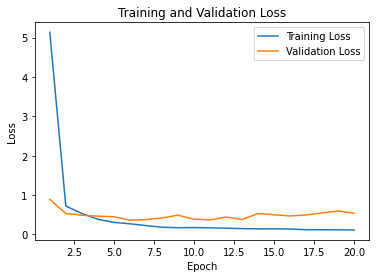

In [39]:
# Plot the loss and accuracy curves for training and validation 
plt.clf()
loss = CNN_Model.history['loss']
val_loss = CNN_Model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

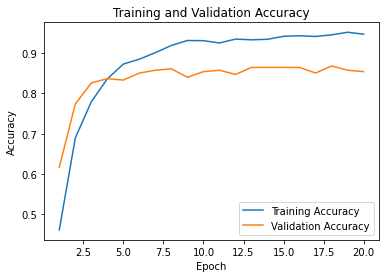

In [40]:
# Plot the loss and accuracy curves for training and validation 

plt.clf()
loss = CNN_Model.history['accuracy']
val_loss = CNN_Model.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
model_results = model.evaluate([x_val, x_val],y_val)
print("Overall Loss:  " + "%.2f" % model_results[0])
print("Overall Accuracy:  " + "%.2f" % model_results[1])

9/9 [==============================] - 3s 277ms/step - loss: 0.5539 - accuracy: 0.8432
Overall Loss:  0.55
Overall Accuracy:  0.84


In [42]:
y_pred_train = model.predict([x_train,x_train])
bad_predictions = (y_pred_train.argmax(axis=1) != y_train)
print('Bad predictions:', sum(bad_predictions))

Bad predictions: 26


Cross folding

In [43]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    results = model.fit([t_x,t_x], t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate([val_x,val_x],val_y))
    return results

In [44]:
n_folds=10
epochs=20
batch_size=128
#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
13/13 [==============================] - 44s 3s/step - loss: 0.1095 - accuracy: 0.9492 - val_loss: 0.0584 - val_accuracy: 0.9674
Epoch 2/20
13/13 [==============================] - 43s 3s/step - loss: 0.1052 - accuracy: 0.9479 - val_loss: 0.0689 - val_accuracy: 0.9783
Epoch 3/20
13/13 [==============================] - 43s 3s/step - loss: 0.0968 - accuracy: 0.9540 - val_loss: 0.0653 - val_accuracy: 0.9783
Epoch 4/20
13/13 [==============================] - 43s 3s/step - loss: 0.0840 - accuracy: 0.9552 - val_loss: 0.0702 - val_accuracy: 0.9891
Epoch 5/20
13/13 [==============================] - 43s 3s/step - loss: 0.0781 - accuracy: 0.9691 - val_loss: 0.0636 - val_accuracy: 0.9783
Epoch 6/20
13/13 [==============================] - 43s 3s/step - loss: 0.0847 - accuracy: 0.9576 - val_loss: 0.0663 - val_accuracy: 0.9728
Epoch 7/20
13/13 [==============================] - 43s 3s/step - loss: 0.0758 - accuracy: 0.9625 - val_loss: 0.0722 - val_accuracy: 0.9783

In [47]:
#uncomment the pip command if shap is not installed
#!pip install shap

import shap
import tensorflow as tf
imageNumber=2
# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train, x_train])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([x_test[imageNumber:imageNumber+1], x_test[imageNumber:imageNumber+1]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


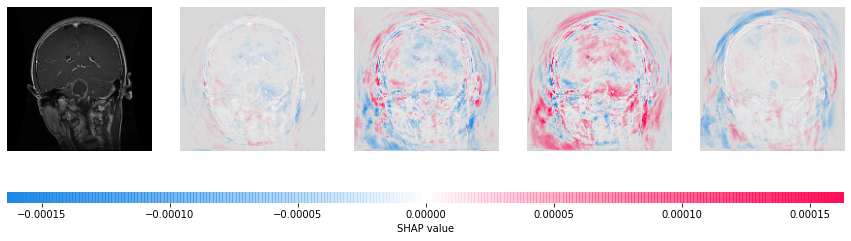

In [48]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(4)], x_test[imageNumber:imageNumber+1])

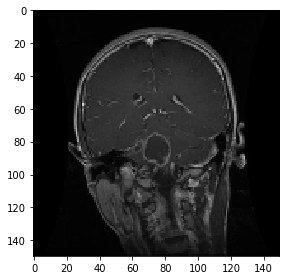

In [49]:
import skimage.io 
import skimage.segmentation
Xi= x_test[imageNumber]
skimage.io.imshow(Xi) # Show image before inception preprocessing

In [50]:
preds = model.predict([x_test,x_test])

In [51]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes  

array([1, 0, 2, 3])

In [52]:
superpixels = skimage.segmentation.quickshift(x_test[imageNumber], kernel_size=3,max_dist=100, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

21

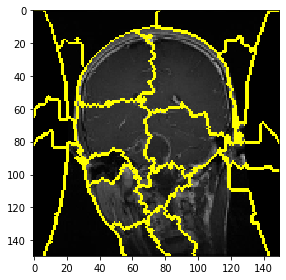

In [53]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(x_test[imageNumber], superpixels))

In [54]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
import copy

def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

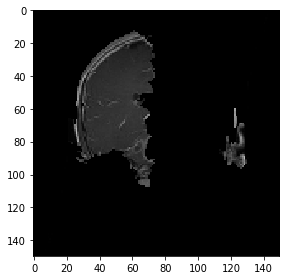

In [56]:
skimage.io.imshow(perturb_image(x_test[imageNumber],perturbations[0],superpixels))